In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

## AutoEncoder

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

import os
from glob import glob
import pandas as pd

In [2]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

In [3]:
import os
os.chdir("../")

In [4]:
pwd

'C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project'

In [5]:
file_path = './dataset/back2/back2/*.jpg'
target_path = './dataset/short_data/short_data/*.jpg'

file_list = glob(file_path)
target_list = glob(target_path)

In [6]:
file_list = file_list[:100000]
target_list = target_list[:100000]

In [7]:
len(target_list)

100000

### DataLoader 생성

In [8]:
data_dict = {'train_path':[], 'target_path':[]}

for i in range(len(file_list)):
    train_path = file_list[i]
    target_path = target_list[i]
    
    data_dict['train_path'].append(train_path)
    data_dict['target_path'].append(target_path)

train_df = pd.DataFrame(data_dict)

train_df.to_csv("./train.csv", mode='w')

In [9]:
df = pd.read_csv('./train.csv')

In [10]:
from torchvision import transforms

transforms_train = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor()]
)

In [11]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Classification_Dataset(Dataset):
    def __init__(self, csv, mode, transform=None):
        self.csv = csv.reset_index(drop=True)  # random으로 섞인 데이터의 인덱스를 reset 시켜서 다시 부여한다.
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]  # csv 파일의 행 개수 == 데이터 개수

    def __getitem__(self, index):   
        row = self.csv.iloc[index]                       # 주어진 index에 대한 데이터 뽑아오기
        train_image = Image.open(row.train_path).convert('RGB') 
        target_image = Image.open(row.target_path).convert('RGB')
        
        if self.transform:
            train_image = self.transform(train_image) # 이미지에 transform 적용하기
            target_image = self.transform(target_image)

        return train_image, target_image  # 이미지와 target return하기

In [12]:
# dataset class 객체 만들기
dataset_train = Classification_Dataset(df, 'train', transform=transforms_train)

from torch.utils.data.sampler import RandomSampler
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,  num_workers=0)

In [13]:
len(train_loader)

1000

### Encoder, Decoder

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16, 32, 3, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2)
        )
        
        self.layer2 = nn.Sequential(
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 32, 3, padding=1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.shape[0], -1)
        return out


In [15]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(32, 32, 3,2, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16)
        )
        
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(16, 16, 3, 1, 1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16, 3, 3, 2, 1,1),
                        nn.ReLU()
        )


    def forward(self,x):
        out = x.view(x.shape[0],32,56,56)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

### model 생성

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


In [17]:
decoder.load_state_dict(torch.load('./model/short_Decoder.pt'))
encoder.load_state_dict(torch.load('./model/short_Encoder.pt'))

<All keys matched successfully>

## Train

In [19]:
for i in tqdm(range(num_epoch)):
    for j,[train_img, target_img] in enumerate(train_loader):
      
        optimizer.zero_grad()
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        output = encoder(train_img)
        output = decoder(output)
        
        loss = loss_func(output, target_img)
        loss.backward()
        optimizer.step()
        
    if i%10==0:
        print('Epoch {0} // Loss : {1}'.format(i+1, loss))
        torch.save(encoder.state_dict(), './model/short_Encoder.pt')
        torch.save(decoder.state_dict(), './model/short_Decoder.pt')

  1%|▊                                                                                     | 1/100 [08:53<14:40:14, 533.48s/it]

Epoch 1 // Loss : 0.005019017495214939


 11%|█████████▍                                                                            | 11/100 [53:21<6:36:13, 267.12s/it]

Epoch 11 // Loss : 0.002946427557617426


 21%|█████████████████▋                                                                  | 21/100 [1:38:22<5:59:54, 273.35s/it]

Epoch 21 // Loss : 0.002717498457059264


 31%|██████████████████████████                                                          | 31/100 [2:23:08<5:07:22, 267.28s/it]

Epoch 31 // Loss : 0.002634490141645074


 41%|██████████████████████████████████▍                                                 | 41/100 [3:07:36<4:21:19, 265.76s/it]

Epoch 41 // Loss : 0.0024664292577654123


 51%|██████████████████████████████████████████▊                                         | 51/100 [3:51:31<3:35:23, 263.75s/it]

Epoch 51 // Loss : 0.002395357470959425


 61%|███████████████████████████████████████████████████▏                                | 61/100 [4:36:25<2:55:42, 270.32s/it]

Epoch 61 // Loss : 0.003626052988693118


 71%|███████████████████████████████████████████████████████████▋                        | 71/100 [5:19:59<2:07:01, 262.83s/it]

Epoch 71 // Loss : 0.002519459230825305


 81%|████████████████████████████████████████████████████████████████████                | 81/100 [6:04:27<1:24:23, 266.52s/it]

Epoch 81 // Loss : 0.0023716753348708153


 91%|██████████████████████████████████████████████████████████████████████████████▎       | 91/100 [6:48:10<39:03, 260.41s/it]

Epoch 91 // Loss : 0.0023837846238166094


100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [7:27:12<00:00, 268.32s/it]


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)

decoder.load_state_dict(torch.load('./model/short_Decoder.pt'))
encoder.load_state_dict(torch.load('./model/short_Encoder.pt'))

<All keys matched successfully>

In [29]:
from PIL import Image

test_image = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\dataset\\back2\\back2\\55415.jpg').convert('RGB') 
test_target = Image.open('C:\\Users\\seojeongP\\Desktop\\2021\\영상처리와 딥러닝\\final_project\\dataset\\short_data\\short_data\\55415.jpg').convert('RGB')

test_image = transforms_train(test_image).unsqueeze(dim=0).to(device)
test_target = transforms_train(test_target).to(device)

print(test_image.shape)
print(test_target.shape)

test_output = encoder(test_image)
test_output = decoder(test_output)

print(torch.squeeze(test_image).shape)

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [30]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


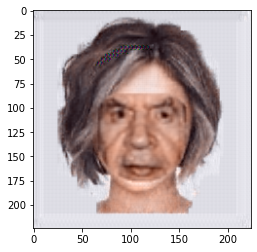

In [31]:
plt.imshow(torch.squeeze(test_output).cpu().detach().numpy().transpose(1, 2, 0))

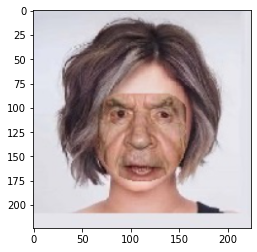

In [32]:
plt.imshow(torch.squeeze(test_target).cpu().detach().numpy().transpose(1, 2, 0))

In [21]:
type(test_output)

numpy.ndarray

In [23]:
cv2.imwrite('./test_output.jpg', test_output)
# cv2.imshow('test_image', test_output)

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:735: error: (-215:Assertion failed) image.channels() == 1 || image.channels() == 3 || image.channels() == 4 in function 'cv::imwrite_'
